#### Desafio:

Objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.

#### 1.0 Importações

In [35]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import sys
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [4]:
# Importando a base de dados
df = pd.read_csv('teste_indicium_precificacao.csv')

#### 2.0 Verificando os dados

In [5]:
df.shape

(48894, 16)

In [6]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Pode-se perceber que a coluna ultima_review é do tipo date e portanto precisaremos entender se a mesma deverá ser tratada.

In [8]:
# Verificando se existem informações duplicadas
df.loc[df.duplicated()]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365


In [9]:
# Identificando a quantidade de valores nulos
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

Valores Ausentes

Nome: Existem 16 entradas sem nome.

Host Name: 21 entradas estão sem o nome do anfitrião.

Ultima Review e Reviews por Mês: Ambas as colunas têm 10.052 entradas faltantes, o que é esperado para listagens sem reviews.

In [9]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Estatísticas Descritivas

Preço: A média é aproximadamente 152,72, mas com um desvio padrão bastante alto de 240,16, indicando uma variação significativa nos preços. O preço máximo é 10.000, o que sugere a presença de outliers.

Mínimo de Noites: A média de noites mínimas é de 7, mas também com um alto desvio padrão, indicando uma grande variação. O valor máximo de 1.250 noites mínimas é claramente atípico.

Número de Reviews: A maioria dos anúncios tem poucos comentários, com uma média de 23,27, mas alguns anúncios têm até 629 comentários.

Disponibilidade: A disponibilidade média ao longo do ano é de 112 dias, mas varia de 0 a 365 dias, indicando que alguns anúncios estão disponíveis o ano todo, enquanto outros não estão disponíveis para reserva. Quanto menos tempo disponível ao longo de 365 dias entende-se que melhor é a região ou o imóvel para aluguel devido a alta demanda.

In [10]:
df.describe(exclude=np.number)

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,48878,48873,48894,48894,48894,38842
unique,47904,11452,5,221,3,1764
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,18,417,21661,3920,25409,1413


Estatistica descritiva das variáveis categóricas

Região: Podemos identificar que possuímos 5 tipos de bairro_group onde Manhattan é o que se destaca com a maior frequência.

Bairro: Podemos identificar que possuímos 221 bairros onde Williamsburg é o que se destaca com a maior frequência.

Tipo de quarto: Podemos identificar que possuímos 3 tipos de quarto onde Entire home/apt é o que se destaca com a maior frequência.

In [11]:
# Verificando a quantidade de imóveis com quantidade de dias disponível menor que a mediana
df_alta_procura = df.loc[df['disponibilidade_365'] < df['disponibilidade_365'].median()].shape[0]
print(f"Imóveis com quantidade de dias disponível menor que a mediana: {df_alta_procura}")
# Verificando a quantidade de imóveis com quantidade de dias disponível menor que a média
df_media_procura = df.loc[df['disponibilidade_365'] < df['disponibilidade_365'].mean()].shape[0]
print(f"Imóveis com quantidade de dias disponível menor que a média: {df_media_procura}")

Imóveis com quantidade de dias disponível menor que a mediana: 24411
Imóveis com quantidade de dias disponível menor que a média: 30274


Verificando a disponibilidade percebe-se que os imóveis mais procurados estão abaixo do segundo quartil o que representa 50% dos nossos anúncios e que aproximadamente 62% dos anúncios estão na média dos mais procurados.

#### 3.0 Preparando os dados

Foi identificado que a coluna ultima_review é do tipo data e portanto realizaremos a conversão.

In [12]:
# Convertendo a coluna com datas de object para o tipo datetime no df_review
df['ultima_review'] = pd.to_datetime(df['ultima_review'])

Foi identificado que há valores nulos nas colunas nome, host_name, ultima_review e reviews_por_mes.

Para as colunas nome e host_name o valor nulo é indiferente para esta análise.

Para as colunas ultima_review e reviews_por_mes, desde que o numero_de_reviews seja zero, podemos entender que não houveram reviews e portanto incluir zero.

In [13]:
# Verificando se todos os registros nulos nas colunas ultima_review e reviews_por_mes também são nulos na coluna numero_de_reviews.
registros_nulos = df[((df['ultima_review'].isnull() & df['reviews_por_mes'].isnull()) & df['numero_de_reviews'] != 0)]
registros_nulos

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365


In [14]:
# Incluindo zeros nos valores nulos nas colunas 
df.fillna({'reviews_por_mes': 0, 'ultima_review' : 0}, inplace=True)

#### 4.0 Visualizações

Verificando a correlação entre as variáveis

In [15]:
# Correlação entre as variáveis numéricas
df.corr(numeric_only=True)

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,1.000000,0.588282,-0.003178,0.090896,0.010618,-0.013235,-0.319782,0.180208,0.133274,0.085541
host_id,0.588282,1.000000,0.020199,0.127049,0.015309,-0.017370,-0.140113,0.209776,0.154951,0.203535
latitude,-0.003178,0.020199,1.000000,0.084777,0.033939,0.024861,-0.015399,-0.018775,0.019517,-0.010926
longitude,0.090896,0.127049,0.084777,1.000000,-0.150020,-0.062750,0.059092,0.138512,-0.114713,0.082751
price,0.010618,0.015309,0.033939,-0.150020,1.000000,0.042799,-0.047954,-0.050564,0.057472,0.081833
minimo_noites,-0.013235,-0.017370,0.024861,-0.062750,0.042799,1.000000,-0.080118,-0.124909,0.127960,0.144320
numero_de_reviews,-0.319782,-0.140113,-0.015399,0.059092,-0.047954,-0.080118,1.000000,0.589406,-0.072376,0.172047
reviews_por_mes,0.180208,0.209776,-0.018775,0.138512,-0.050564,-0.124909,0.589406,1.000000,-0.047313,0.163760
calculado_host_listings_count,0.133274,0.154951,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.047313,1.000000,0.225711
disponibilidade_365,0.085541,0.203535,-0.010926,0.082751,0.081833,0.144320,0.172047,0.163760,0.225711,1.000000


<Axes: >

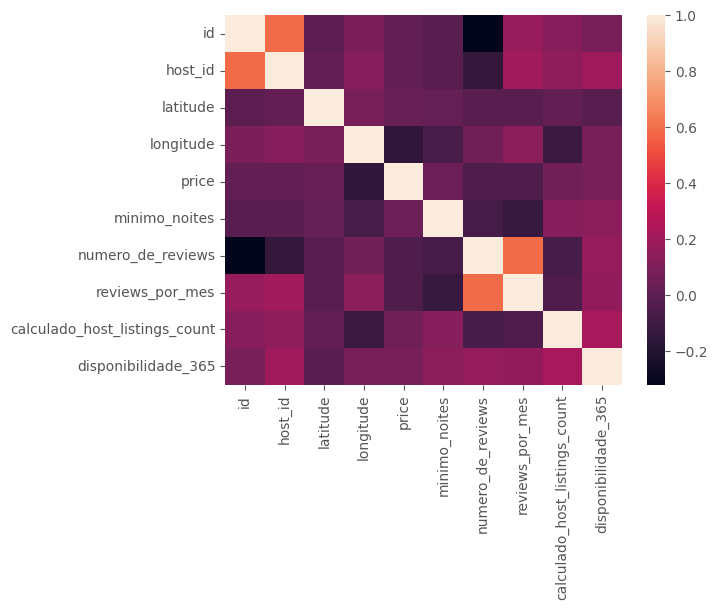

In [16]:
# Visualização gráfica da correlação das variáveis numéricas
sns.heatmap(df.corr(numeric_only=True))

De modo geral as variáveis não apresentam correlação linear forte ou significativa com a variável target price, assim como não apresentam entre si.

Verificando a influência do bairro no preço

In [17]:
# Influência do bairro no preço
precos_por_bairro = df.groupby('bairro_group')['price'].mean().sort_values(ascending=False)

precos_por_bairro

bairro_group
Manhattan        196.875814
Brooklyn         124.381983
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64

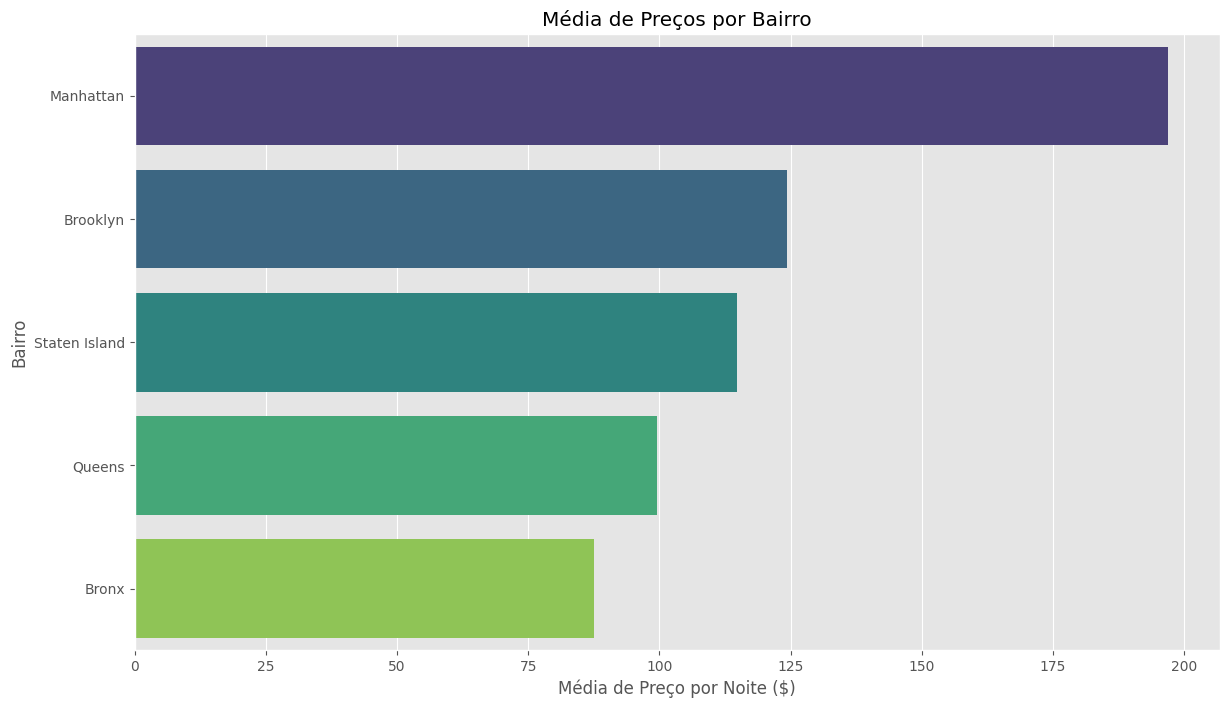

In [18]:
# Gráfico de barras para mostrar a média de preços por bairro
plt.figure(figsize=(14, 8))
sns.barplot(x=precos_por_bairro.values, y=precos_por_bairro.index, palette="viridis")
plt.title('Média de Preços por Bairro')
plt.xlabel('Média de Preço por Noite ($)')
plt.ylabel('Bairro')
plt.show()

Os preços médios por noite variam significativamente entre os bairros de Nova York, com Manhattan liderando com um preço médio de aproximadamente 196,88, seguido por Brooklyn 124,38, Staten Island 114,81, Queens 99,52, e Bronx 87,50. Isso sugere que o bairro é um fator importante na determinação dos preços dos aluguéis temporários, com Manhattan sendo o mais caro.

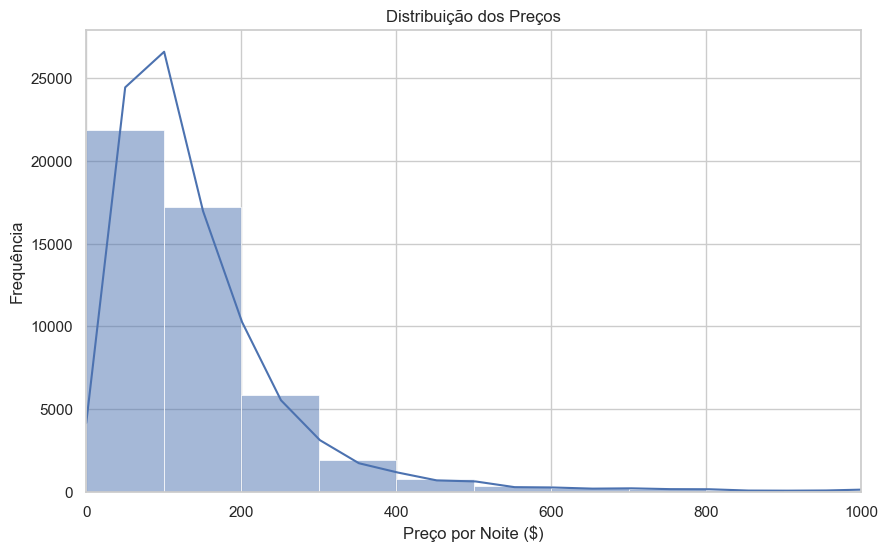

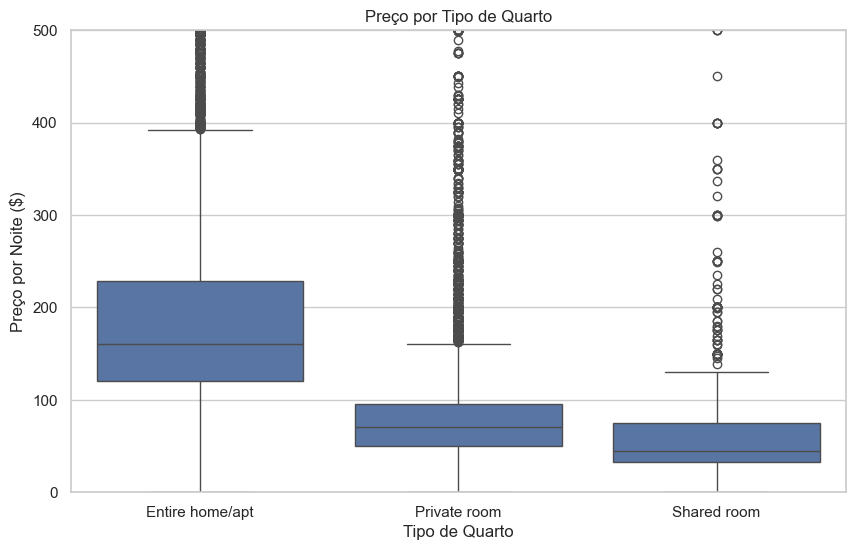

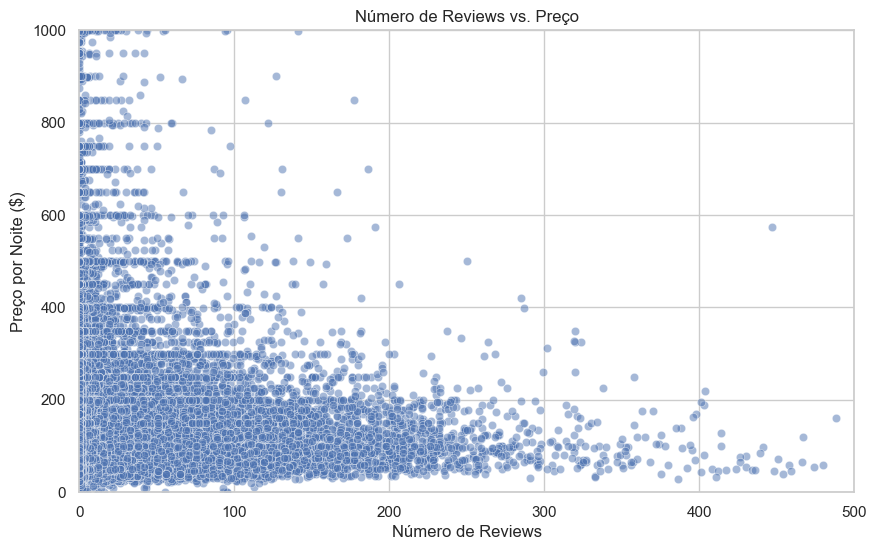

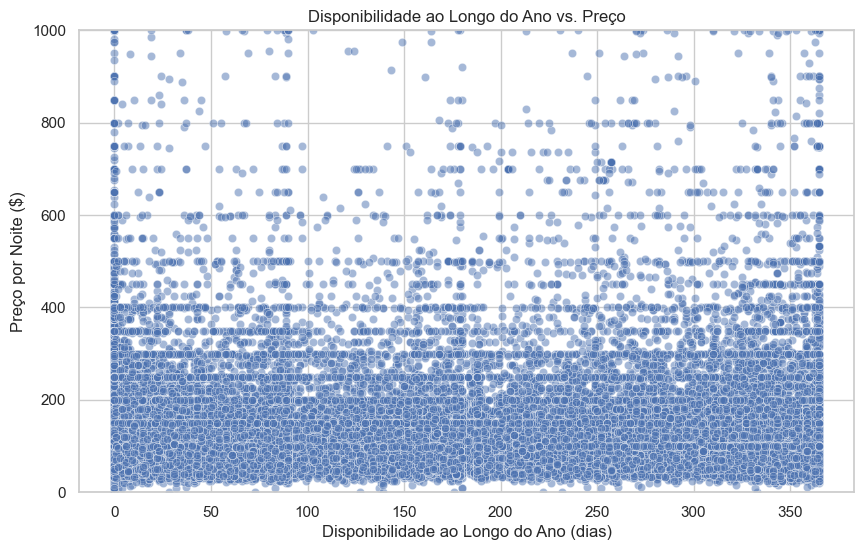

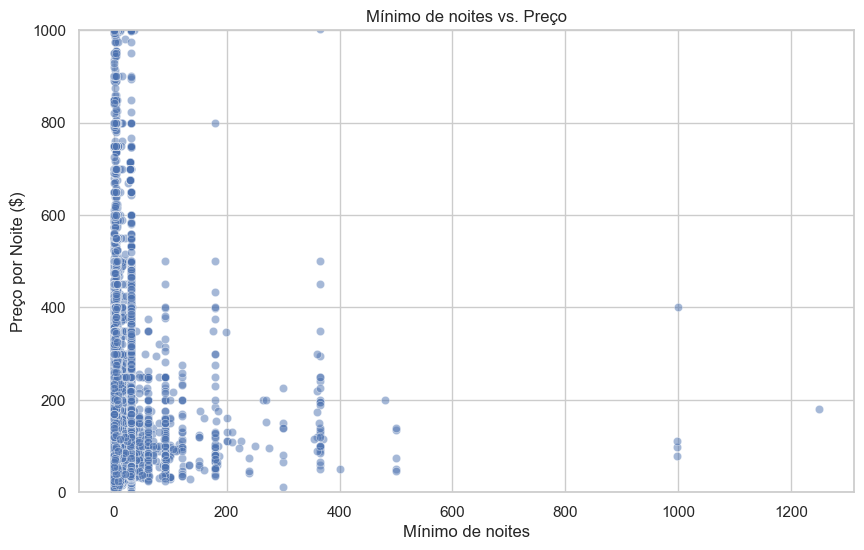

In [19]:
# Configurações de estilo para os gráficos
sns.set_theme(style="whitegrid")

# Distribuição dos Preços
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Distribuição dos Preços')
plt.xlabel('Preço por Noite ($)')
plt.ylabel('Frequência')
plt.xlim(0, 1000)  # Limitar para visualizar melhor a distribuição até 1000
plt.show()

# Tipo de Quarto vs. Preço
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='room_type', y='price')
plt.title('Preço por Tipo de Quarto')
plt.xlabel('Tipo de Quarto')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 500)  # Limitar para visualizar melhor os preços até 500
plt.show()

# Número de Reviews vs. Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='numero_de_reviews', y='price', alpha=0.5)
plt.title('Número de Reviews vs. Preço')
plt.xlabel('Número de Reviews')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 1000)  # Limitar para visualizar melhor os preços até 1000
plt.xlim(0, 500)  # Limitar número de reviews para visualizar melhor
plt.show()

# Disponibilidade vs. Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='disponibilidade_365', y='price', alpha=0.5)
plt.title('Disponibilidade ao Longo do Ano vs. Preço')
plt.xlabel('Disponibilidade ao Longo do Ano (dias)')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 1000)  # Limitar para visualizar melhor os preços até 1000
plt.show()

# Mínimo de noites vs. Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='minimo_noites', y='price', alpha=0.5)
plt.title('Mínimo de noites vs. Preço')
plt.xlabel('Mínimo de noites')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 1000)  # Limitar para visualizar melhor os preços até 1000
plt.show()

Gráfico 1: A distribuição dos preços mostra uma concentração significativa de anúncios com preços mais baixos, com a maioria dos anúncios custando menos de 200 por noite. Existe uma longa cauda para a direita, indicando a presença de alguns anúncios com preços muito altos, o que sugere outliers ou propriedades de luxo.

Gráfico 2: Os preços variam significativamente com o tipo de quarto. Os apartamentos/casas inteiros tendem a ser mais caros do que quartos privados e compartilhados, o que é esperado devido à maior privacidade e espaço. Isso indica uma preferência clara dos consumidores por espaços privativos, refletindo-se nos preços mais altos para essas categorias.

Gráfico 3: Não há uma correlação clara entre o número de reviews e o preço. Anúncios com uma ampla gama de preços têm variados números de reviews, sugerindo que fatores além do preço influenciam a popularidade de um anúncio, como localização, qualidade e características únicas da propriedade.

Gráfico 4: Também não observamos uma correlação direta entre a disponibilidade ao longo do ano e o preço. Propriedades com diferentes níveis de disponibilidade têm uma ampla gama de preços. Isso pode indicar estratégias de precificação variadas entre os anfitriões, possivelmente baseadas em demanda sazonal, preferências pessoais ou políticas de reserva.

Gráfico 5: Também não observamos uma correlação direta entre o mínimo de noites e o preço. Propriedades com diferentes quantidades de mínimo de noite têm uma ampla gama de preços.

In [20]:
colunas_numericas = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365', 'price']

# Calcule o IQR para cada coluna
Q1 = df[colunas_numericas].quantile(0.25)
Q3 = df[colunas_numericas].quantile(0.75)
IQR = Q3 - Q1

# Identifique os outliers
outliers = ((df[colunas_numericas] < (Q1 - 1.5 * IQR)) | (df[colunas_numericas] > (Q3 + 1.5 * IQR))).any(axis=1)

# Exclua os outliers do DataFrame
df_sem_outliers = df[~outliers]

# Exibir informações antes e depois da exclusão de outliers
print("Número de linhas antes da exclusão de outliers:", len(df))
print("Número de linhas após a exclusão de outliers:", len(df_sem_outliers))

Número de linhas antes da exclusão de outliers: 48894
Número de linhas após a exclusão de outliers: 29706


Por ser uma abordagem mais comum e simples (e também baseado no meu conhecimento), foi utilizado o IQR para remoção dos outliers. Afinal, IQR é uma métrica útil mesmo para distribuições que não seguem uma forma normal, o que o torna versátil para diferentes tipos de dados.

O Intervalo Interquartil (IQR) é comumente utilizado para identificar e remover outliers porque ele é uma medida de dispersão que se concentra na distribuição central dos dados, ignorando os extremos. 

Retirando as colunas que não serão utilizadas para criação do modelo uma vez que baseado nas informações anteriores não interferem direta ou indiretamente no preço.

In [21]:
df_otimizado = df_sem_outliers.drop(axis=1, columns=['id', 'nome', 'host_id', 'host_name','latitude', 'longitude','ultima_review'])

#### 5.0 Modelo de ML

##### Dividindo os dados de treino e teste

In [22]:
from sklearn.model_selection import train_test_split

# Seleção de variáveis e transformações
X = df_otimizado.drop('price', axis=1)
y = df_otimizado['price']

# Codificação one-hot para variáveis categóricas
X = pd.get_dummies(X)

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Modelo de árvore de decisão

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Inicializar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)

# Treinar o modelo
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10, random_state=42)

Random Forest:

Prós: Boa performance em dados complexos, lida bem com relações não lineares (boa opção para os dados que possuímos).

Contras: Menos interpretabilidade.

In [24]:
from sklearn.metrics import mean_squared_error

# Prever os preços no conjunto de teste
rf_y_pred = rf_model.predict(X_test)

# Calcular o MSE
rf_mse = mean_squared_error(y_test, rf_y_pred)
print(f'Erro quadrático médio (Random Forest): {rf_mse}')

# Calcular RMSE
rmse = np.sqrt(rf_mse)
print(f'RMSE: {rmse:.2f}')

Erro quadrático médio (Random Forest): 2225.564838451122
RMSE: 47.18


O Mean Squared Error (MSE) é uma métrica de avaliação comum em problemas de regressão, como prever preços. O MSE calcula a média dos quadrados dos erros entre as previsões do modelo e os valores reais. 

A interpretação do MSE depende da escala da variável de destino. No caso do preço de aluguel, a unidade é em dólares, e o MSE está em termos de dólares ao quadrado. Para obter uma métrica mais fácil de interpretar, consideramos calcular a raiz quadrada do MSE, conhecida como Raiz Quadrada do Erro Quadrático Médio (Root Mean Squared Error - RMSE). O RMSE teria a mesma unidade que a variável de destino (dólares, neste caso).

Assim obtemos um valor que representa o erro médio em termos da unidade da variável de destino. Isso facilita a interpretação e comparação com os valores reais.

In [25]:
# Comparando previsões com valor atual
df_comp = pd.DataFrame({'Atual': np.round(y_test, 0), 
                   'Previsto': np.round(rf_y_pred, 0)})
df_comp.head(10)

,Atual,Previsto
13934,39,78.0
13943,60,76.0
30175,260,137.0
23312,77,85.0
22351,150,167.0
22168,79,87.0
4195,140,170.0
16484,129,192.0
14597,139,109.0
31741,170,171.0


##### Modelo de regressão linear

In [26]:
from sklearn.linear_model import LinearRegression

# Inicializar o modelo
lr_model = LinearRegression()

# Treinar o modelo
lr_model.fit(X_train, y_train)

# Prever os preços no conjunto de teste
lr_y_pred = lr_model.predict(X_test)

Regressão Linear:

Prós: Simplicidade, interpretabilidade, rápido treinamento.

Contras: Assume uma relação linear entre as variáveis, pode não capturar relações não lineares.

In [27]:
# Calcular RMSE diretamente
from sklearn import metrics
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test,lr_y_pred)))

RMSE 49301535.98616731


In [28]:
# Comparando os valores atuais com o previsto
df_comp = pd.DataFrame({'Atual': np.round(y_test, 0), 
                   'Previsto': np.round(lr_y_pred, 0)})
df_comp.head(10)

,Atual,Previsto
13934,39,84.0
13943,60,86.0
30175,260,162.0
23312,77,82.0
22351,150,142.0
22168,79,84.0
4195,140,175.0
16484,129,200.0
14597,139,117.0
31741,170,173.0


Como teste e parte do aprendizado realizei a criação de 2 modelos, um utilizando Random Forest e outro utilizando Regressão Linear a fim de estudo e comparação. Mas para o desafio uma vez que por conceito o Random Forest se enquadra melhor por não termos dados lineares, vou utilizá-lo como padrão para o envio.

#### 6.0 Respostas

##### 1 - Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

R: Baseado nos dados que possuímos é compreensível que o local mais indicado para compra seria em Manhattan levando em consideração a média dos valores cobrados no aluguel, porém se existir à disposição mais dados com informações como os valores do m² ou dos imóveis, não é descartada a indicação de outro local.

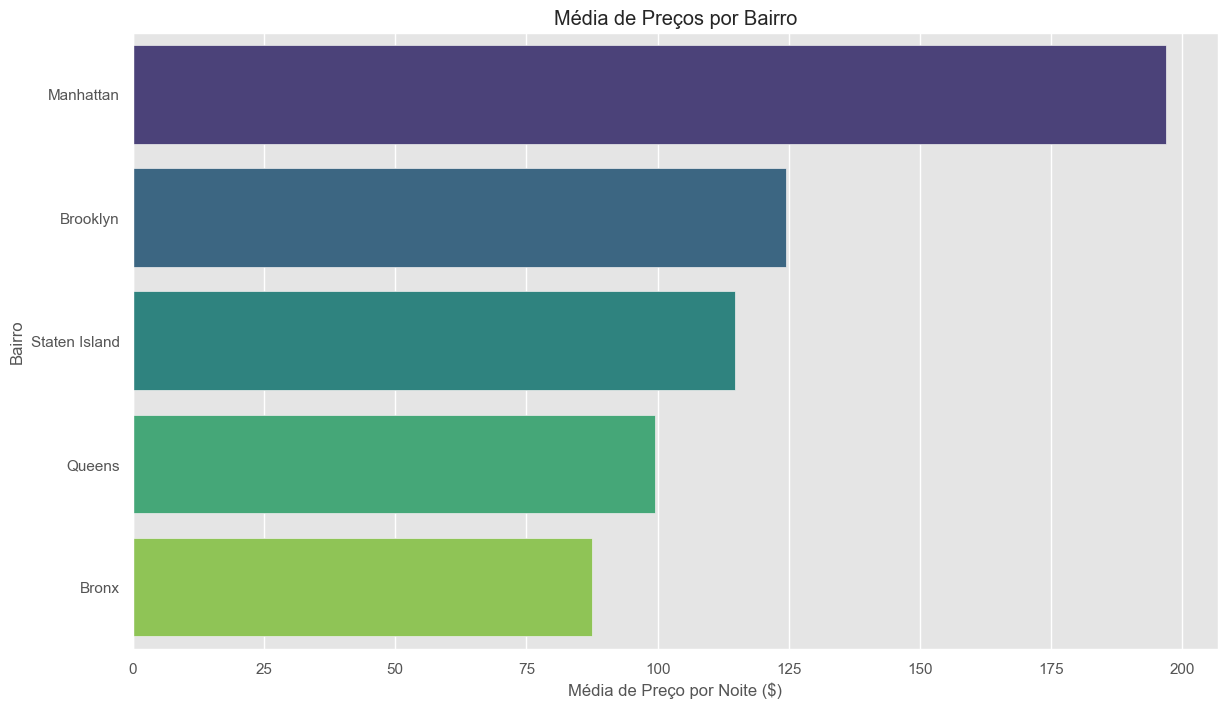

In [101]:
# Gráfico de barras para mostrar a média de preços por bairro
plt.figure(figsize=(14, 8))
sns.barplot(x=precos_por_bairro.values, y=precos_por_bairro.index, palette="viridis")
plt.title('Média de Preços por Bairro')
plt.xlabel('Média de Preço por Noite ($)')
plt.ylabel('Bairro')
plt.show()

##### 2 - O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

R: Não foi observada correlação direta entre a disponibilidade ao longo do ano e o preço assim como entre o mínimo de noites e o preço, portanto, baseado nos dados que possuímos podemos observar que essas variáveis não interferem no preço diretamente.

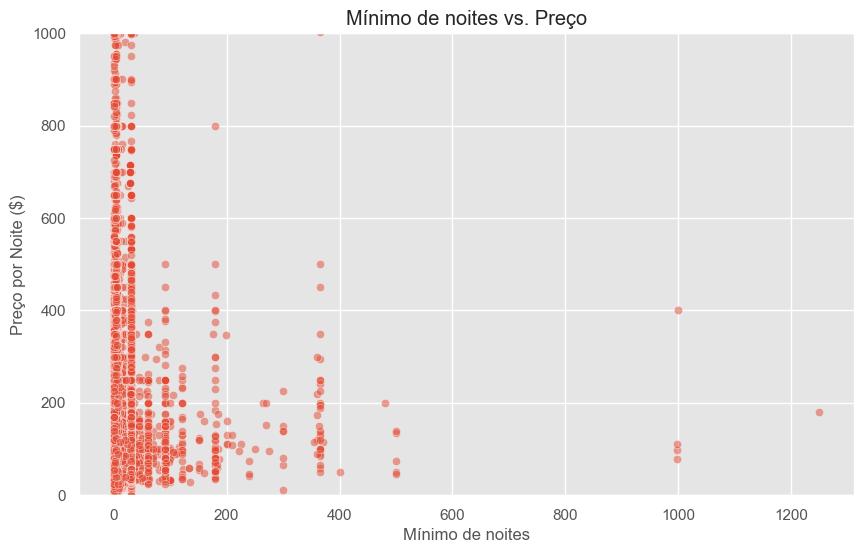

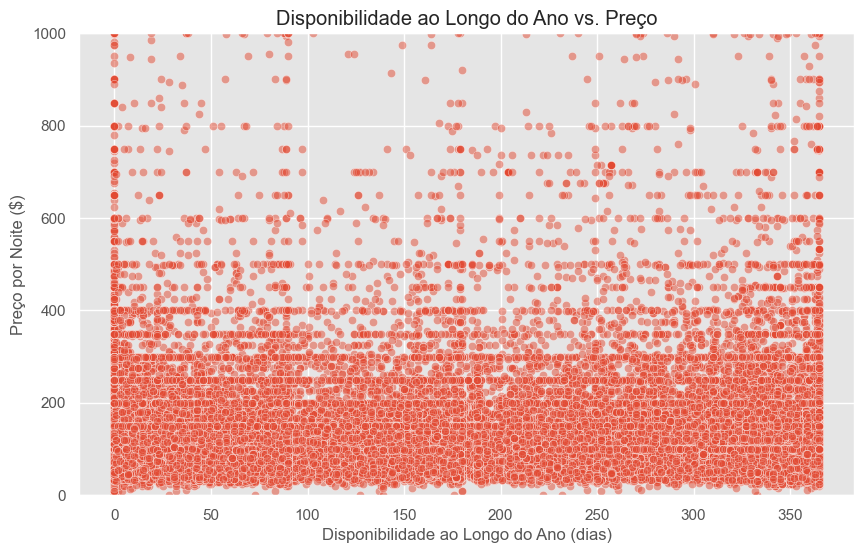

In [102]:
# Mínimo de noites vs. Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='minimo_noites', y='price', alpha=0.5)
plt.title('Mínimo de noites vs. Preço')
plt.xlabel('Mínimo de noites')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 1000)  # Limitar para visualizar melhor os preços até 1000
plt.show()

# Disponibilidade vs. Preço
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='disponibilidade_365', y='price', alpha=0.5)
plt.title('Disponibilidade ao Longo do Ano vs. Preço')
plt.xlabel('Disponibilidade ao Longo do Ano (dias)')
plt.ylabel('Preço por Noite ($)')
plt.ylim(0, 1000)  # Limitar para visualizar melhor os preços até 1000
plt.show()

##### 3 - Existe algum padrão no texto do nome do local para lugares de mais alto valor?

<Axes: title={'center': 'Top 10 palavras utilizadas'}, xlabel='word'>

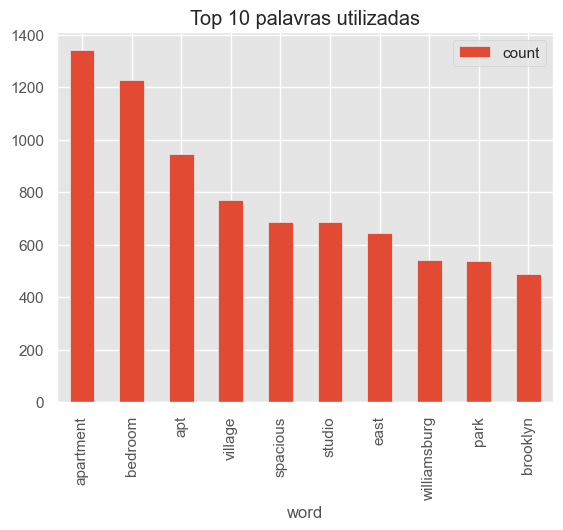

In [104]:

# Filtrando os dados para manter apenas anúncios com preço acima do 75º percentil
altos_precos = df_sem_outliers[df_sem_outliers['price'] > df_sem_outliers['price'].quantile(0.75)]

# Analisando o texto dos nomes para identificar palavras comuns
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(altos_precos['nome'].dropna())  # Remover valores NaN para a análise de texto
word_counts = np.asarray(X.sum(axis=0)).ravel()
words = np.array(vectorizer.get_feature_names_out())

# Criar um DataFrame para visualizar as palavras mais comuns
palavras_freq = pd.DataFrame({'word': words, 'count': word_counts})
top_palavras = palavras_freq.sort_values(by='count', ascending=False).head(10)

top_palavras.plot(kind='bar', x='word', y='count', title='Top 10 palavras utilizadas')

Com base na análise das palavras-chave identificadas nos nomes dos locais, podemos observar alguns padrões que podem indicar características associadas a lugares de mais alto valor. Aqui estão algumas observações:

Palavras que indicam Tamanho/Qualidade:

"Bedroom" (Quarto): Indica a quantidade de quartos, o que pode influenciar o preço.
"Spacious" (Espaçoso), "Luxury" (Luxo), "Private" (Privado), "Beautiful" (Bonito), "Modern" (Moderno): Descrições de características que geralmente estão associadas a propriedades de maior valor.

Palavras que indicam Tipo de Propriedade:

"Apartment" (Apartamento), "Apt": Indicam o tipo de propriedade. Apartamentos, especialmente aqueles descritos como "luxo" ou "moderno", podem ter preços mais elevados.

Palavras que indicam Localização:

"Manhattan", "Williamsburg", "Brooklyn", "East", "West": Indicam localização geográfica. Bairros específicos em Manhattan e áreas populares como Williamsburg em Brooklyn geralmente têm preços mais altos.
Esses padrões sugerem que a quantidade de quartos, características da propriedade (como ser espaçoso ou luxuoso) e a localização geográfica podem estar associadas a lugares de mais alto valor.

##### 4 - Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

Qual seria a sua sugestão de preço?

**Obs.: Apesar do 'price' ter sido definido nas características do imóvel, não considerei este valor uma vez que o intuito do modelo é predizer tal informação.**

In [ ]:
# Inserindo os dados de um novo apt na variável
novo_apt = {'id': 2595,
            'nome': 'Skylit Midtown Castle',
            'host_id': 2845,
            'host_name': 'Jennifer',
            'bairro_group': 'Manhattan',
            'bairro': 'Midtown',
            'latitude': 40.75362,
            'longitude': -73.98377,
            'room_type': 'Entire home/apt',
            'price': 225,
            'minimo_noites': 1,
            'numero_de_reviews': 45,
            'ultima_review': '2019-05-21',
            'reviews_por_mes': 0.38,
            'calculado_host_listings_count': 2,
            'disponibilidade_365': 355}

In [44]:
# Lista de colunas
lista_de_colunas = X_test.columns.to_list()

# Criar um dicionário com chaves iguais à lista de colunas e valores zerados
dicionario = {coluna: False for coluna in lista_de_colunas}
dicionario_df = pd.DataFrame([dicionario])

# Converta o dicionário em um DataFrame pandas para facilitar a codificação one-hot
novo_apt_df = pd.DataFrame([novo_apt]).drop(axis=1, columns=['id', 'nome', 'host_id', 'host_name','latitude', 'longitude','ultima_review', 'price'])

# Aplique a codificação one-hot para variáveis categóricas
novo_apt_encoded = pd.get_dummies(novo_apt_df)

# Preencha quaisquer valores nulos, se houver
novo_apt_encoded = novo_apt_encoded.fillna(0)

# Preencher as informações do new_apartment_encoded no dicionario_df
dicionario_df.loc[0, novo_apt_encoded.columns] = novo_apt_encoded.iloc[0]

In [45]:
# Fazendo a previsão usando o modelo random forest treinado
predicted_price = rf_model.predict(dicionario_df.values.reshape(1,-1))
print(f'Preço Previsto para o Novo Apartamento: {predicted_price[0]:.2f}')

Preço Previsto para o Novo Apartamento: 216.08


In [31]:
# Fazendo a previsão usando o modelo de regressão linear treinado
lr_predict = lr_model.predict(dicionario_df)
print(f'Preço Previsto para o Novo Apartamento: {int(round(lr_predict[0])):.2f}')

Preço Previsto para o Novo Apartamento: 230.00


Salvando o modelo no formato .pkl

In [32]:
with open('LH_CD_PEDROHENRIQUECARVALHONUNES.pkl', 'wb') as file:
    pickle.dump(rf_model, file)